# Library

In [55]:
try:
    import json 
    import csv
    import os
    import networkx as nx
    import pandas as pd
    import plotly.express as px
    import numpy as np
    import matplotlib as mpl
    import random
    import powerlaw
    import pygraphviz
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from math import sin, cos, sqrt, atan2, radians
    import folium
    from folium import plugins, Figure, Map
    from networkx.drawing.nx_agraph import graphviz_layout
    from metro import multiplex as mx
    from empiricaldist import Cdf
except ModuleNotFoundError as er:
    print(er)
    %pip install --upgrade pip
    %pip install --upgrade wheel
    %pip install --upgrade folium
    %pip install --upgrade pandas
    %pip install --upgrade networkx
    %pip install --upgrade plotly.express
    %pip install --upgrade numpy
    %pip install --global-option=build_ext ` --global-option="-IC:\Program Files\Graphviz\include" ` --global-option="-LC:\Program Files\Graphviz\lib" ` pygraphviz
    %pip install powerlaw
    %pip install empiricaldist
    %pip install pexpect
    %pip install pickleshare
    %pip install python-igraph
    %pip install simplegeneric
    %pip install traitlets
    %pip install wsgiref

try:
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Line3DCollection
except ModuleNotFoundError as er:
    print(er)
    %pip install mpl_toolkits

# From GeoJSON to Multiplex Graph

In [42]:
class ParisTransportation:
    """
    Main class
    """

    def __init__(self):
        self.jsonfile = "geojson/multigraph.geojson"

    def clean_data(self):
        if not os.path.exists("gml"):
            os.makedirs("gml")

        G = nx.DiGraph() #total
        H = nx.DiGraph() #road
        Q = nx.Graph() #metro
        I = nx.Graph() #train
        O = nx.Graph() #tram

        with open(self.jsonfile, 'r') as jsfile:
            for line in jsfile:
                jsentry = json.loads(line)
                if jsentry['properties']['type'] == "edge":
                    if 'direction' in jsentry['properties']:
                        if jsentry['properties']['direction'] == "Double sens":
                            direction = "TwoWay"
                        elif (jsentry['properties']['direction'] == "Sens inverse" 
                            or jsentry['properties']['direction'] == "Sens unique"):
                            direction = "OneWay"
                    else:
                        direction = "TwoWay"

                    ID = jsentry['_id']['$oid']
                    Source = jsentry['properties']['mongo_org_id']
                    Target = jsentry['properties']['mongo_dest_id']
                    Layer = jsentry['properties']['layer']
                    Coordinates = jsentry['geometry']['coordinates']
                    Direction = direction

                    try:
                        Length = jsentry['properties']['length']
                    except:
                        Length = None
                    try:
                        Name = jsentry['properties']['name']
                        if Name.startswith("54"):
                            Name = None
                    except:
                        Name = None

                    degreeDual = jsentry['properties']['degreeDual']

                    #print(f"[{Layer}] -> {Direction}")
                    
                    """if Direction == "OneWay" and Layer == "road":
                        H.add_edge(
                            Source, 
                            Target, 
                            id = ID, 
                            coord = Coordinates, 
                            length=Length, 
                            name=Name, 
                            degreeDual=degreeDual,
                            layer=Layer)
                        H.nodes[Source]['pos'] = (Coordinates[0][1],Coordinates[0][0])
                        H.nodes[Source]['layer'] = Layer
                        H.nodes[Target]['pos'] = (Coordinates[1][1],Coordinates[1][0])
                        H.nodes[Target]['layer'] = Layer"""

                    if Layer == "road":
                        if Direction == "TwoWay":
                            H.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual, layer=Layer)
                            #H.add_edge(Target, Source, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual, layer=Layer)
                        elif Direction == "OneWay":
                            H.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual, layer=Layer)
                        H.nodes[Source]['lat'] = Coordinates[0][1]
                        H.nodes[Source]['lon'] = Coordinates[0][0]
                        H.nodes[Source]['pos'] = f"{H.nodes[Source]['lat']},{H.nodes[Source]['lon']}"
                        H.nodes[Source]['layer'] = Layer

                        H.nodes[Target]['lat'] = Coordinates[1][1]
                        H.nodes[Target]['lon'] = Coordinates[1][0]
                        H.nodes[Target]['pos'] = f"{H.nodes[Target]['lat']},{H.nodes[Target]['lon']}"
                        H.nodes[Target]['layer'] = Layer

                    elif Layer == "metro":
                        Q.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual,
                            layer=Layer)
                        #Q.add_edge(Target, Source, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual)
                        Q.nodes[Source]['lat'] = Coordinates[0][1]
                        Q.nodes[Source]['lon'] = Coordinates[0][0]
                        Q.nodes[Source]['pos'] = f"{Q.nodes[Source]['lat']},{Q.nodes[Source]['lon']}"
                        Q.nodes[Source]['layer'] = Layer

                        Q.nodes[Target]['lat'] = Coordinates[1][1]
                        Q.nodes[Target]['lon'] = Coordinates[1][0]
                        Q.nodes[Target]['pos'] = f"{Q.nodes[Target]['lat']},{Q.nodes[Target]['lon']}"
                        Q.nodes[Target]['layer'] = Layer

                    elif Layer == "train":
                        I.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual,
                            layer=Layer)
                        #I.add_edge(Target, Source, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual)
                        I.nodes[Source]['lat'] = Coordinates[0][1]
                        I.nodes[Source]['lon'] = Coordinates[0][0]
                        I.nodes[Source]['pos'] = f"{I.nodes[Source]['lat']},{I.nodes[Source]['lon']}"
                        I.nodes[Source]['layer'] = Layer

                        I.nodes[Target]['lat'] = Coordinates[1][1]
                        I.nodes[Target]['lon'] = Coordinates[1][0]
                        I.nodes[Target]['pos'] = f"{I.nodes[Target]['lat']},{I.nodes[Target]['lon']}"
                        I.nodes[Target]['layer'] = Layer

                    elif Layer == "tram":
                        O.add_edge(Source, Target, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual,
                            layer=Layer)
                        #O.add_edge(Target, Source, id = ID, coord = Coordinates, length=Length, name=Name, degreeDual=degreeDual)
                        O.nodes[Source]['lat'] = Coordinates[0][1]
                        O.nodes[Source]['lon'] = Coordinates[0][0]
                        O.nodes[Source]['pos'] = f"{O.nodes[Source]['lat']},{O.nodes[Source]['lon']}"
                        O.nodes[Source]['layer'] = Layer

                        O.nodes[Target]['lat'] = Coordinates[1][1]
                        O.nodes[Target]['lon'] = Coordinates[1][0]
                        O.nodes[Target]['pos'] = f"{O.nodes[Target]['lat']},{O.nodes[Target]['lon']}"
                        O.nodes[Target]['layer'] = Layer

                    else:
                        continue
                else:
                    continue

            return(G, H, Q, I, O)


    def geoJSON(self):
        df = pd.read_json('geojson/multigraph.geojson', lines=True)
        id = pd.json_normalize(df["_id"])
        id = id.rename(columns={"$oid": "ID"})

        geom = pd.json_normalize(df["geometry"])
        geom = geom.rename(columns={"type": "LP"})

        prop = pd.json_normalize(df["properties"])

        new_df = pd.concat([id, geom, prop], axis=1)
        return(new_df)
    
    class MapMaker:
        def __init__(self, df):
            self.df = df
            self.only_point = df.loc[df['LP'] == "Point"]
            self.points = self.only_point.coordinates.tolist()
            self.center = (48.85654066902656, 2.349154275836)
            self.canvas = True,
            self.bounds = True,
            self.filename = "france.html"
            self.layerColor = {
                "road": "green",
                "train": "blue",
                "metro": "gray",
                "tram": "purple"
            }

        @staticmethod
        def calculate_distance(lon1, lat1, lon2, lat2, R=6357):
            lat1 = radians(lat1)
            lat2 = radians(lat2)
            lon1 = radians(lon1)
            lon2 = radians(lon2)

            dlon = lon2 - lon1
            dlat = lat2 - lat1

            a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))

            distance = R * c
            return distance
        
        def create_map(self):
            if not os.path.exists(self.filename):
                m = Map(location=[self.center[0], self.center[1]], 
                    tiles="CartoDB positron", 
                    min_zoom=7, 
                    zoom_start=9,
                    zoom_control=True, 
                    min_lat=42, 
                    max_lat=54, 
                    min_lon=-10, 
                    max_lon=14, 
                    max_bounds=self.bounds,
                    prefer_canvas=self.canvas)

                minimap = plugins.MiniMap()
                m.add_child(minimap)

                layers = self.only_point.layer.unique().tolist()

                fg = FeatureGroup(control=False, show=False)
                m.add_child(fg)

                f1 = plugins.FeatureGroupSubGroup(fg, layers[0].capitalize())
                m.add_child(f1)

                f2 = plugins.FeatureGroupSubGroup(fg, layers[1].capitalize())
                m.add_child(f2)

                f3 = plugins.FeatureGroupSubGroup(fg, layers[2].capitalize())
                m.add_child(f3)

                f4 = plugins.FeatureGroupSubGroup(fg, layers[3].capitalize())
                m.add_child(f4)

                i = 0
                layerTypes = self.only_point.layer.tolist()

                for lon, lat in self.points:

                    distance = self.calculate_distance(lon, lat, self.center[1], self.center[0])
                    radiusDistance = distance

                    if int(distance) > 0:
                        distance = int(distance)
                        distance = f"{distance} km"
                    else:
                        distance = distance * 1000
                        distance = int(distance)
                        distance = f"{distance} mt"

                    circle = Circle(
                        location=(lat, lon),
                        tooltip=f"<strong>Type:</strong> {layerTypes[i]}<br><strong>Center distance:</strong> {distance}",
                        radius=sqrt(radiusDistance * 1000),
                        popup=f"<strong>Type:</strong> {layerTypes[i]}<br><strong>Lat:</strong> {lat}<br><strong>Long:</strong> {lon}<br><strong>Center distance:</strong> {distance}",
                        color=self.layerColor.get(layerTypes[i]),
                        fill=False,
                        fill_color=self.layerColor.get(layerTypes[i])
                    )
                    
                    if layerTypes[i] == layers[0]:
                        f1.add_child(circle)
                    elif layerTypes[i] == layers[1]:
                        f2.add_child(circle)
                    elif layerTypes[i] == layers[2]:
                        f3.add_child(circle)
                    elif layerTypes[i] == layers[3]:
                        f4.add_child(circle)

                    i +=1

                paris = Circle(
                    location=(self.center[0], self.center[1]),
                    tooltip="Center",
                    popup="",
                    radius=80,
                    color="crimson",
                    fill=True,
                    fill_color="crimson"
                )
                paris.add_to(fg)

                plugins.Fullscreen(
                        position="topright",
                        title="Fullscreen",
                        title_cancel="Exit fullscreen",
                        force_separate_button=True,
                    ).add_to(m)

                LayerControl().add_to(m)
                m.save(self.filename)

In [43]:
G, ROAD, METRO, TRAIN, TRAM = ParisTransportation().clean_data()

In [44]:
df = ParisTransportation().geoJSON()

In [45]:
ParisTransportation().MapMaker(df).create_map()

# Summary of Multiplex Network Layers

In [46]:
CC_TRAIN = TRAIN.subgraph(max(nx.connected_components(TRAIN), key=len))
CC_TRAM = TRAM.subgraph(max(nx.connected_components(TRAM), key=len))
#CC_ROAD = ROAD.subgraph(max(nx.connected_components(ROAD), key=len)) #TODO: Fixed #ERRORE https://stackoverflow.com/questions/47283612/networkx-node-connected-component-not-implemented-for-directed-type
CC_ROAD = ROAD.subgraph(max(nx.strongly_connected_components(ROAD), key=len))

In [47]:
summary_table = pd.DataFrame({
    "Nodes" : [
        len(METRO.nodes), 
        len(TRAIN.nodes),
        len(TRAM.nodes),
        len(ROAD.nodes)],
    "Edges" : [
        len(METRO.edges), 
        len(TRAIN.edges),
        len(TRAM.edges),
        len(ROAD.edges)],
    "Avg. Degree" : [
        round(sum(dict(METRO.degree()).values())/float(len(METRO)),3),
        round(sum(dict(TRAIN.degree()).values())/float(len(TRAIN)),3),
        round(sum(dict(TRAM.degree()).values())/float(len(TRAM)),3),
        round(sum(dict(ROAD.degree()).values())/float(len(ROAD)),3)],
    "Reference" : ["OSM", "OSM", "OSM", "IGN"]
}, index=["Metro", "Train", "Tram", "Road"])
summary_table

,Nodes,Edges,Avg. Degree,Reference
Metro,303,356,2.350,OSM
Train,241,244,2.025,OSM
Tram,144,140,1.944,OSM
Road,14804,22281,3.010,IGN


# Nodes distribution

In [48]:
DF = df.loc[df['LP'] == "Point"]
DF = DF.drop_duplicates(subset="ID")
px.pie(
    values=DF.groupby('layer')['layer'].count().sort_values(ascending=False).values.tolist(), 
    names=DF.groupby('layer')['layer'].count().sort_values(ascending=False).index.tolist(), 
    title='Nodes distribution')

# 3D Plot of Layers

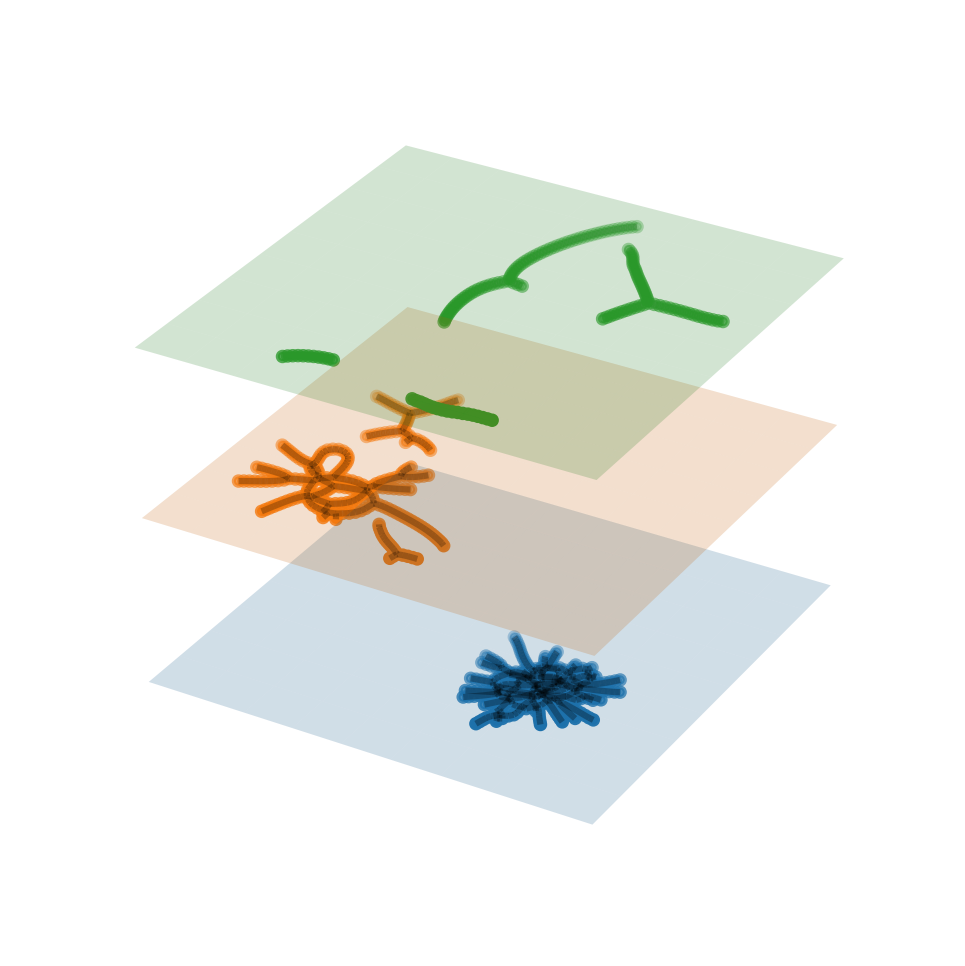

In [49]:
mpl.rcParams['figure.dpi'] = 300
class LayeredNetworkGraph(object):

    def __init__(self, graphs, node_labels=None, layout=nx.spring_layout, ax=None):
        """Given an ordered list of graphs [g1, g2, ..., gn] that represent
        different layers in a multi-layer network, plot the network in
        3D with the different layers separated along the z-axis.

        Within a layer, the corresponding graph defines the connectivity.
        Between layers, nodes in subsequent layers are connected if
        they have the same node ID.

        Arguments:
        ----------
        graphs : list of networkx.Graph objects
            List of graphs, one for each layer.

        node_labels : dict node ID : str label or None (default None)
            Dictionary mapping nodes to labels.
            If None is provided, nodes are not labelled.

        layout_func : function handle (default networkx.spring_layout)
            Function used to compute the layout.

        ax : mpl_toolkits.mplot3d.Axes3d instance or None (default None)
            The axis to plot to. If None is given, a new figure and a new axis are created.

        """

        # book-keeping
        self.graphs = graphs
        self.total_layers = len(graphs)

        self.node_labels = node_labels
        self.layout = layout

        if ax:
            self.ax = ax
        else:
            fig = plt.figure()
            self.ax = fig.add_subplot(111, projection='3d')

        # create internal representation of nodes and edges
        self.get_nodes()
        self.get_edges_within_layers()
        self.get_edges_between_layers()

        # compute layout and plot
        self.get_node_positions()
        self.draw()


    def get_nodes(self):
        """Construct an internal representation of nodes with the format (node ID, layer)."""
        self.nodes = []
        for z, g in enumerate(self.graphs):
            self.nodes.extend([(node, z) for node in g.nodes()])


    def get_edges_within_layers(self):
        """Remap edges in the individual layers to the internal representations of the node IDs."""
        self.edges_within_layers = []
        for z, g in enumerate(self.graphs):
            self.edges_within_layers.extend([((source, z), (target, z)) for source, target in g.edges()])


    def get_edges_between_layers(self):
        """Determine edges between layers. Nodes in subsequent layers are
        thought to be connected if they have the same ID."""
        self.edges_between_layers = []
        for z1, g in enumerate(self.graphs[:-1]):
            z2 = z1 + 1
            h = self.graphs[z2]
            shared_nodes = set(g.nodes()) & set(h.nodes())
            self.edges_between_layers.extend([((node, z1), (node, z2)) for node in shared_nodes])


    def get_node_positions(self, *args, **kwargs):
        """Get the node positions in the layered layout."""
        # What we would like to do, is apply the layout function to a combined, layered network.
        # However, networkx layout functions are not implemented for the multi-dimensional case.
        # Futhermore, even if there was such a layout function, there probably would be no straightforward way to
        # specify the planarity requirement for nodes within a layer.
        # Therefor, we compute the layout for the full network in 2D, and then apply the
        # positions to the nodes in all planes.
        # For a force-directed layout, this will approximately do the right thing.
        # TODO: implement FR in 3D with layer constraints.

        composition = self.graphs[0]
        for h in self.graphs[1:]:
            composition = nx.compose(composition, h)

        pos = self.layout(composition, *args, **kwargs)

        self.node_positions = dict()
        for z, g in enumerate(self.graphs):
            self.node_positions.update({(node, z) : (*pos[node], z) for node in g.nodes()})


    def draw_nodes(self, nodes, *args, **kwargs):
        x, y, z = zip(*[self.node_positions[node] for node in nodes])
        self.ax.scatter(x, y, z, *args, **kwargs)


    def draw_edges(self, edges, *args, **kwargs):
        segments = [(self.node_positions[source], self.node_positions[target]) for source, target in edges]
        line_collection = Line3DCollection(segments, *args, **kwargs)
        self.ax.add_collection3d(line_collection)


    def get_extent(self, pad=0.1):
        xyz = np.array(list(self.node_positions.values()))
        xmin, ymin, _ = np.min(xyz, axis=0)
        xmax, ymax, _ = np.max(xyz, axis=0)
        dx = xmax - xmin
        dy = ymax - ymin
        return (xmin - pad * dx, xmax + pad * dx), \
            (ymin - pad * dy, ymax + pad * dy)


    def draw_plane(self, z, *args, **kwargs):
        (xmin, xmax), (ymin, ymax) = self.get_extent(pad=0.1)
        u = np.linspace(xmin, xmax, 10)
        v = np.linspace(ymin, ymax, 10)
        U, V = np.meshgrid(u ,v)
        W = z * np.ones_like(U)
        self.ax.plot_surface(U, V, W, *args, **kwargs)


    def draw_node_labels(self, node_labels, *args, **kwargs):
        for node, z in self.nodes:
            if node in node_labels:
                ax.text(*self.node_positions[(node, z)], node_labels[node], *args, **kwargs)


    def draw(self):

        self.draw_edges(self.edges_within_layers,  color='k', alpha=0.3, linestyle='-', zorder=2)
        self.draw_edges(self.edges_between_layers, color='k', alpha=0.3, linestyle='--', zorder=2)

        for z in range(self.total_layers):
            self.draw_plane(z, alpha=0.2, zorder=1)
            self.draw_nodes([node for node in self.nodes if node[1]==z], s=5, zorder=3)

        if self.node_labels:
            self.draw_node_labels(self.node_labels,
                                  horizontalalignment='center',
                                  verticalalignment='center',
                                  zorder=100)


if __name__ == '__main__':

    # define graphs
    n = 5
    g = METRO
    h = TRAIN
    i = TRAM

    node_labels = {nn : str(nn) for nn in range(4*n)}

    # initialise figure and plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    LayeredNetworkGraph([g, h, i], ax=ax, layout=graphviz_layout) # graphviz
    ax.set_axis_off()
    plt.show()

In [50]:
pd.DataFrame.from_dict(dict(METRO.nodes(data=True)), orient='index')

,lat,lon,pos,layer
5453b63455474a3362317782,48.846854,2.316651,"48.8468543,2.3166512",metro
5453b63555474a336231a0f6,48.849140,2.321898,"48.8491398,2.3218984",metro
5453b63555474a336231a9a0,48.840669,2.228718,"48.840669,2.2287175",metro
5453b63455474a3362318fdf,48.842000,2.238733,"48.8420002,2.2387333",metro
5453b63555474a336231a0ba,48.849905,2.348746,"48.8499051,2.348746",metro
...,...,...,...,...
5453b63555474a336231a245,48.880777,2.374112,"48.8807774,2.3741125",metro
5453b63455474a33623182c5,48.874954,2.340210,"48.8749537,2.3402103",metro
5453b63455474a336231776c,48.846474,2.365911,"48.846474,2.3659107",metro
5453b63355474a33623172b0,48.886963,2.386713,"48.8869632,2.3867135",metro


In [56]:
class TransportMap:
    def __init__(self, metro_layer, train_layer, tram_layer):
        self.metro_layer = metro_layer
        self.train_layer = train_layer
        self.tram_layer = tram_layer
    
    @staticmethod
    def edges2df(G, id_indexed: bool = True):
        df = pd.DataFrame(dict(G.edges()).items(),columns = ['Source-Target', 'Values'])
        df = pd.concat([df.drop(['Source-Target'], axis=1), df['Source-Target'].apply(pd.Series)], axis=1).rename(columns={0: "source", 1: "target"})
        df = pd.concat([df.drop(['Values'], axis=1), df['Values'].apply(pd.Series)], axis=1)
        if id_indexed is True:
            df = df.set_index('id')
        return(df) 

    """def centerCoord(self): # WORK IN PROGRESS

        center = ()
        return center"""
    
    def drawMap(self, line_width: int):
        fig = Figure(width=1000,height=500)
        #m = folium.plugins.DualMap(location=[48, 2], tiles='cartodbpositron', zoom_start=5)
        m = folium.Map(location=[48.857001, 2.341848], zoom_start=9.5, tiles="CartoDBpositron")
        fig.add_child(m)

        f1=folium.FeatureGroup("Tram")
        f1.add_to(m)
        f2=folium.FeatureGroup("Metro")
        f2.add_to(m)
        f3=folium.FeatureGroup("Train")
        f3.add_to(m)

        folium.TileLayer('Stamen Terrain').add_to(m)
        folium.TileLayer('Stamen Toner').add_to(m)
        folium.TileLayer('Stamen Water Color').add_to(m)
        folium.TileLayer('cartodbpositron').add_to(m)
        folium.TileLayer('cartodbdark_matter').add_to(m)
        folium.LayerControl().add_to(m)

        train_df = self.edges2df(self.train_layer)
        metro_df = self.edges2df(self.metro_layer)
        tram_df = self.edges2df(self.tram_layer)

        for segment in train_df.coord:
            segment[0][0],segment[0][1] = segment[0][1],segment[0][0]
            segment[1][0],segment[1][1] = segment[1][1],segment[1][0]
            folium.vector_layers.PolyLine(
                segment,
                popup='<b>Train Network</b>',
                tooltip='Train',
                color='green',
                weight=line_width).add_to(f3)

        for segment in metro_df.coord:
            segment[0][0],segment[0][1] = segment[0][1],segment[0][0]
            segment[1][0],segment[1][1] = segment[1][1],segment[1][0]
            folium.vector_layers.PolyLine(
                segment,
                popup='<b>Metro Network</b>',
                tooltip='Metro',
                color='blue',
                weight=line_width).add_to(f2)

        for segment in tram_df.coord:
            segment[0][0],segment[0][1] = segment[0][1],segment[0][0]
            segment[1][0],segment[1][1] = segment[1][1],segment[1][0]
            folium.vector_layers.PolyLine(
                segment,
                popup='<b>Tram Network</b>',
                tooltip='Tram',
                color='orange',
                weight=line_width).add_to(f1)
        
        folium.GeoJson({
    "type": "LineString",
    "coordinates": [[-100, 40], [-105, 45], [-110, 55]]
}).add_to(f1)
        fmtr = "function(num) {return L.Util.formatNum(num, 3) + ' º ';};"
        folium.plugins.MousePosition(position='topright', separator=' | ', prefix="Mouse:",
              lng_formatter=fmtr, lat_formatter=fmtr).add_to(m)
        folium.plugins.LocateControl().add_to(m)
        folium.plugins.MiniMap(tile_layer='Stamen WaterColor', position='bottomright').add_to(m)
        folium.plugins.Draw(
            export=True,
            filename='my_data.geojson',
            position='topleft',
            draw_options={'polyline': {'allowIntersection': False}},
            edit_options={'poly': {'allowIntersection': False}}
        ).add_to(m)
        folium.plugins.Geocoder(collapsed=False, position='topright', add_marker=True).add_to(m)
        folium.plugins.Fullscreen(position='topleft', title='Full Screen', title_cancel='Exit Full Screen', force_separate_button=False).add_to(m)
        folium.plugins.MeasureControl(position='topright', primary_length_unit='kilometers', secondary_length_unit='meters').add_to(m)
        m.save('france_transport.html')
        return(m)
    

In [57]:
metro_df = TransportMap(METRO, TRAIN, TRAM).edges2df(METRO)
train_df = TransportMap(METRO, TRAIN, TRAM).edges2df(TRAIN)
tram_df = TransportMap(METRO, TRAIN, TRAM).edges2df(TRAM)

In [58]:
train_df

,source,target,coord,length,name,degreeDual,layer
id,,,,,,,
54b7bef755474a2bb2744f10,5453b63555474a336231aedb,5453b63455474a3362317e21,"[[2.6503883, 48.7956697], [2.6902929, 48.770724]]",4.030165,RER E,338,train
54b7bef855474a2bb2748f70,5453b63555474a336231aedb,5453b63455474a3362317f60,"[[2.6184322, 48.8061102], [2.6503883, 48.79566...",2.612619,RER E,338,train
54b7bef855474a2bb2747093,5453b63455474a3362317e21,5453b63455474a3362319236,"[[2.7285636, 48.7454489], [2.6902929, 48.770724]]",3.971016,RER E,338,train
54b7bef755474a2bb2744f11,5453b63455474a33623188f0,5453b63555474a336231ab6f,"[[2.5801235, 48.8230136], [2.5425275, 48.82325...",2.752504,RER E,338,train
54b7bef855474a2bb2749542,5453b63455474a33623188f0,5453b63455474a3362317f60,"[[2.6184322, 48.8061102], [2.5801235, 48.82301...",3.376532,RER E,338,train
...,...,...,...,...,...,...,...
54b7bef855474a2bb27499bf,5453b63455474a33623198d5,5453b63455474a33623184a4,"[[2.22314127514, 48.895632969], [2.18450665388...",3.978122,RER A,853,train
54b7bef855474a2bb274a0b6,5453b63455474a33623198d5,5453b63455474a33623177da,"[[2.23758257184, 48.8921319365], [2.2231412751...",1.125230,RER A,853,train
54b7bef855474a2bb274a0b5,5453b63455474a33623184a4,5453b63555474a336231a429,"[[2.15721464809, 48.9377726159], [2.1845066538...",2.742727,RER A,853,train


In [59]:
TransportMap(METRO, TRAIN, TRAM).drawMap(line_width=3)

In [60]:
#[[2.50806859096, 48.7709967645], [2.50534535329, 48.7530423598]]
ParisTransportation().MapMaker(df).calculate_distance(2.50806859096, 48.7709967645, 2.50534535329, 48.7530423598)

2.001983632128826

In [61]:
m = mx.multiplex()
m.summary()

OD: none 

layer           	nodes 	edges
----------------------------------------


In [62]:
m.add_layers({'metro'   : METRO,
              'train' : TRAIN,
              'tram' : TRAM })
m.summary()

AttributeError: 'DiGraph' object has no attribute 'node'

In [63]:
m.spatial_join2(layer1 = 'metro', # connect every node of metro
               layer2 = 'tram', # to the nearest node of streets
               distance_threshold = 500, # m of distance between nodes
               transfer_speed = 1, # how fast the connection is traversed -- this is essentially 'free'
               base_cost = 0, # fixed waiting cost, e.g. average of 5 minutes for the train to come
               both = False) # bidirectional transfer

AttributeError: 'DiGraph' object has no attribute 'node'

In [ ]:
m.summary()

In [ ]:
N = m.layers_as_subgraph(m.get_layers())
N.edges()


In [ ]:
def spatial_join(self, layer1, layer2, distance_threshold,ost, capacity,
    
        def find_nearest(n, N1) 
            dists = {m: analysis.distance( (N1.node[n]['lon'], N1.node[n]['lat']), (N2.node[m]['lon'], N2.node[m]['lat']) ) for m in}
            nearest = min(dists, key=dists.)
            nearest_dist = dists[near]
            return nearest

        transfer_layer_name = layer1 + '--' + layer2
        self.layers.append(transfer_layer_name)

        layer1_copy = self.layers_as_subgraph([layer1])	
        layer2_copy = self.layers_as_subgraph([layer2])

        edges_added = 0
        for n in layer1_copy.node:
            nearest, nearest_dist = find_nearest(n, layer1_copy, layer2_copy)
            self.G.add_edge(n, nearest, 
                            layer = transfer_layer_name,
                            weight = 0,
                            dist_km = nearest_dist, 
                            free_flow_time_m = nearest_dist / transfer_speed + base_cost,
                            uniform_time_m = nearest_dist / transfer_speed + base_cost,
                            capacity = capacity)
            
            bidirectional = ""
            if both: 
                self.G.add_edge(nearest, n, 
                                layer = transfer_layer_name,
                                weight = 0,
                                dist_km = nearest_dist, 
                                free_flow_time_m = nearest_dist / transfer_speed + base_cost,
                                uniform_time_m = nearest_dist / transfer_speed + base_cost,
                                capacity = capacity) # assumes bidirectional
                bidirectional = "bidirectional "
            edges_added += 1

        print ('Added ' + str(edges_added) + ' ' + bidirectional + 'transfers between '  + layer1 + ' and ' + layer2 + '.')

In [ ]:
def haversine(lon1, lat1, lon2, lat2, R=6357):
    """
    Compute distance between two points
    """
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    lon1 = radians(lon1)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance


def centorid(pos1: tuple, pos2: tuple) -> tuple:
        """
        pos1: tuple (lat, lon)
        pos2: tuple (lat, lon)

        return: (avg_lat,avg_lon)
        """

        avg_lat = (pos1[0]+pos2[0])/2
        avg_lon = (pos1[1]+pos2[1])/2
        return (avg_lat, avg_lon)


def spatial_join2(self, layer1, layer2, distance_threshold: int, transfer_speed, base_cost, both: bool = True):
    """
    
    """

    transfer_layer_name = layer1 + '--' + layer2
    self.layers.append(transfer_layer_name)

    layer1_copy = self.layers_as_subgraph([layer1])	
    layer2_copy = self.layers_as_subgraph([layer2])

    edges_added = 0

    for n in layer1_copy.node:
        for m in layer2_copy.node:
            dist = int(haversine((layer1_copy.node[n]['lon'], layer1_copy.node[n]['lat']), (layer2_copy.node[m]['lon'], layer2_copy.node[m]['lat']))*1000)
            if dist <= distance_threshold:
                self.G.add_edge(n, m, 
                        layer = transfer_layer_name,
                        weight = 0,
                        dist_km = dist, 
                        free_flow_time_m = dist / transfer_speed + base_cost,
                        uniform_time_m = dist / transfer_speed + base_cost)
        
                bidirectional = ""
                if both: 
                    self.G.add_edge(m, n, 
                        layer = transfer_layer_name,
                        weight = 0,
                        dist_km = dist, 
                        free_flow_time_m = dist / transfer_speed + base_cost,
                        uniform_time_m = dist / transfer_speed + base_cost) # assumes bidirectional
                    bidirectional = "bidirectional "
                edges_added += 1

    print ('Added ' + str(edges_added) + ' ' + bidirectional + 'transfers between '  + layer1 + ' and ' + layer2 + '.')

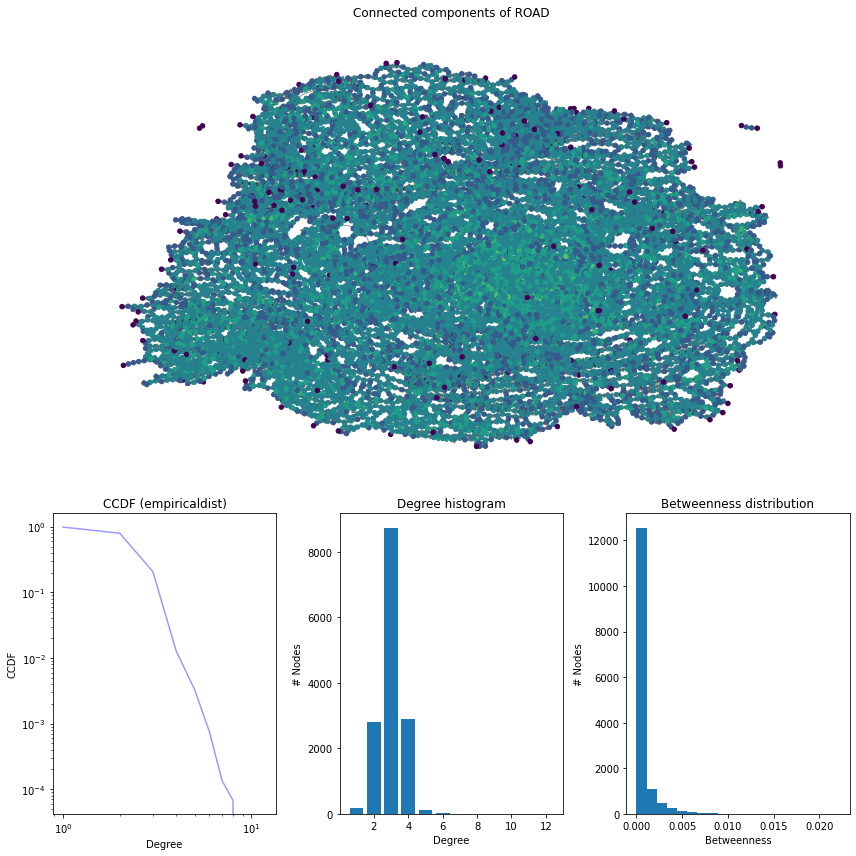

In [ ]:


def degree_analysis(G, method: str):
    fig = plt.figure("Degree of a random graph", figsize=(12, 12))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 9)

    ax0 = fig.add_subplot(axgrid[0:3, :])

    if not G.is_directed() and not G.is_connected():
        Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    else:
        Gcc = G

    n_color = np.asarray([Gcc.degree[n] for n in Gcc.nodes])
    pos = graphviz_layout(Gcc)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color=n_color).set_norm(mcolors.LogNorm())
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    ax0.set_title(f"Connected components of {str(G.nodes()[random.choice(list(G.nodes()))]['layer']).upper()}") #pick layer name of a random node and set it upper in title
    ax0.set_axis_off()
    divider = make_axes_locatable(ax0)

    ax1 = fig.add_subplot(axgrid[3:, :3])

    if method == "empiricaldist":
        degrees = [G.degree(u) for u in G]
        cdf = Cdf.from_seq(degrees, name="distribution")
        (1-cdf).plot(color="b", alpha=.4)
        #decorate(xlabel="Degree", xscale="log", ylabel="CCDF", yscale="log")
        #ax1.plot(, "b-", marker="o")
        #ax1.set_title("CCDF")
        
    elif method == "powerlaw":
        M = nx.to_scipy_sparse_matrix(G)
        xmin = min([d[1] for d in G.degree()])
        indegrees = M.sum(0).A[0]
        degree = np.bincount(indegrees)
        fit = powerlaw.Fit(np.array(degree)+1, fit_method = "KS")
        fit.power_law.plot_pdf(color="r",linestyle="--",label="fit ccdf")
        fit.plot_ccdf()

    ax1.set_title(f"CCDF ({method})")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("CCDF")
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    divider = make_axes_locatable(ax1)
    

    ax2 = fig.add_subplot(axgrid[3:, 3:6])
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# Nodes")
    divider = make_axes_locatable(ax2)

    ax3 = fig.add_subplot(axgrid[3:, 6:])
    B = nx.betweenness_centrality(G, normalized=True)
    betweenness_sequence = list(B.values())
    counts, bins, patches = plt.hist(betweenness_sequence, bins=20)
    ax3.set_title("Betweenness distribution")
    ax3.set_xlabel("Betweenness")
    ax3.set_ylabel("# Nodes")
    divider = make_axes_locatable(ax3)

    fig.tight_layout()
    plt.savefig(f"ccdf_degree_{G.nodes()[random.choice(list(G.nodes()))].get('layer')}.png", dpi = 400)
    plt.show()

degree_analysis(ROAD, method="empiricaldist")

In [ ]:
def network_summary(network_list: list):
    all_data = {}
    for net in network_list:
        hubs = []
        # NET CC for disconnected workaround
        if not net.is_directed():
            net_cc = net.subgraph(sorted(nx.connected_components(net), key=len, reverse=True)[0])

        # get network name (layer)
        net_name = str(net.nodes()[random.choice(list(net.nodes()))]['layer']).capitalize()

        # nodes with highest degree along with position
        degree_sequence = sorted(net.degree, key=lambda x: x[1], reverse=True)
        max_degree = degree_sequence[0][1]
        for node in degree_sequence:
            if node[1] == max_degree:
                hubs.append((node[0], net.nodes[node[0]]['pos']))
        
        # highest degree centrality and node with position
        node_degree_centrality = max(nx.degree_centrality(net), key=nx.degree_centrality(net).get)
        node_degree_centrality = (node_degree_centrality, net.nodes[node_degree_centrality].get('pos'))
        highest_degree_centrality = max(nx.degree_centrality(net).values())

        # density of net
        density = nx.density(net)

        # shortest path
        if not net.is_directed():
            if not nx.is_connected(net):
                shortest_path = nx.average_shortest_path_length(net_cc)
            else:
                shortest_path = nx.average_shortest_path_length(net)
        else:
            shortest_path = None

        # diameter
        if not net.is_directed():
            if not nx.is_connected(net):
                diameter = nx.diameter(net_cc)
            else:
                diameter = nx.diameter(net)
        else:
            diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(net)])

        # cluster
        avg_cluster = nx.average_clustering(net)
        transitivity = nx.transitivity(net)

        # bridge
        if not net.is_directed():
            bridges = len(list(nx.bridges(net)))
        else:
            bridges = None

        # highest betweenness centrality and node with position
        node_between_centrality = max(nx.betweenness_centrality(net), key=nx.betweenness_centrality(net).get)
        node_between_centrality = (node_between_centrality, net.nodes[node_between_centrality].get('pos'))
        max_between_centrality = max(nx.betweenness_centrality(net).values())

        # highest eigenvector centrality and node with position
        node_eigen_centrality = max(nx.eigenvector_centrality(net,max_iter=5000), key=nx.eigenvector_centrality(net,max_iter=5000).get)
        node_eigen_centrality = (node_eigen_centrality, net.nodes[node_eigen_centrality].get('pos'))
        max_eigen_centrality = max(nx.eigenvector_centrality(net,max_iter=5000).values())

        current_data = {
            "max_degree": max_degree,
            "hubs": hubs,
            "density": density,
            "shortest_path": shortest_path,
            "diameter": diameter,
            "avg_cluster": avg_cluster,
            "transitivity": transitivity,
            "bridges": bridges,
            "max_degree_centrality": highest_degree_centrality,
            "node_degree_centrality": node_degree_centrality,
            "max_between_centrality": max_between_centrality,
            "node_between_centrality": node_between_centrality,
            "max_eigen_centrality": max_eigen_centrality,
            "node_eigen_centrality": node_eigen_centrality
        }
        all_data[net_name] = current_data
        #print(f"{net_name} network with max degree {max_degree} hold by nodes:\n{hubs}\n")
        #print(f"{net_name} network has a density of {density}\n")
        #print("----------------------------------------")
    df = pd.DataFrame.from_dict(all_data)
    return(df)
network_summary(network_list=[METRO,TRAIN,TRAM,ROAD])

,Metro,Train,Tram,Road
max_degree,8,4,3,12
hubs,"[(5453b63455474a3362319751, 48.8583398,2.34670...","[(5453b63455474a33623177a4, 48.6897337,2.38305...","[(5453b63455474a3362319105, 48.9387357,2.35626...","[(5453b63455474a33623195f2, 48.87381661472036,..."
density,0.007781,0.008437,0.013598,0.000102
shortest_path,12.208948,16.546039,20.739423,None
diameter,34,47,61,187
avg_cluster,0.008809,0.0,0.0,0.032883
transitivity,0.018634,0,0,0.069418
bridges,115,152,140,None
max_degree_centrality,0.02649,0.016667,0.020979,0.000811
node_degree_centrality,"(5453b63455474a3362319751, 48.8583398,2.3467014)","(5453b63455474a33623177a4, 48.6897337,2.3830533)","(5453b63455474a3362319105, 48.9387357,2.3562637)","(5453b63455474a33623195f2, 48.87381661472036,2..."


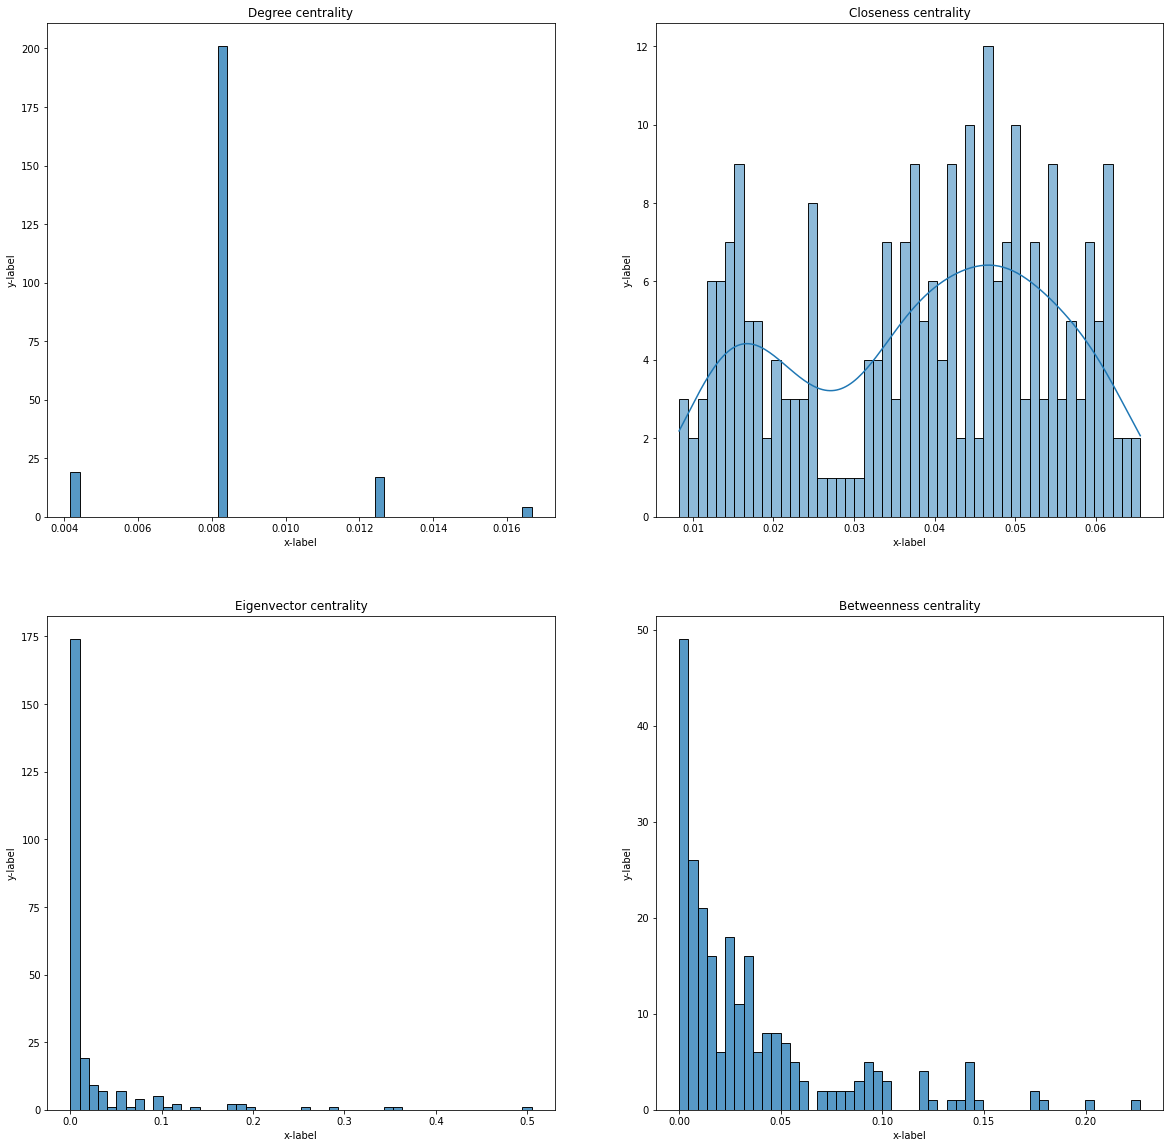

In [ ]:
import seaborn as sns
"""sns.displot(
    data=corr_df, 
    x = "closeness_centrality",
    kde=True, 
    color = 'darkblue')"""

def centrality_measure(G, bins: int = 50):
    # get network name (layer)
    net_name = str(G.nodes()[random.choice(list(G.nodes()))]['layer']).capitalize()

    degree_centrality = list(nx.degree_centrality(G).values())
    closeness_centrality = list(nx.closeness_centrality(G).values())
    eigenvector_centrality = list(nx.eigenvector_centrality(G,max_iter=1000).values())
    betweenness_centrality = list(nx.betweenness_centrality(G).values())

    fig, axs = plt.subplots(2, 2)
    sns.histplot(ax=axs[0, 0], x=degree_centrality, bins=bins).set_title("Degree centrality")
    sns.histplot(ax=axs[0, 1], x=closeness_centrality, bins=bins, kde=True).set_title("Closeness centrality")
    sns.histplot(ax=axs[1, 0], x=eigenvector_centrality, bins=bins).set_title("Eigenvector centrality")
    sns.histplot(ax=axs[1, 1], x=betweenness_centrality, bins=bins).set_title("Betweenness centrality")

    for ax in axs.flat:
        ax.set(xlabel='x-label', ylabel='y-label')

    df = pd.DataFrame({
        "degree_centrality": degree_centrality,
        "closeness_centrality": closeness_centrality,
        "eigenvector_centrality": eigenvector_centrality,
        "betweenness_centrality": betweenness_centrality
    })

    return fig, df

fig, corr_df = centrality_measure(TRAIN, bins=50)

In [ ]:
corr = corr_df.corr()
corr.style.background_gradient(axis=None).set_precision(3).set_properties(**{'font-size': '13pt'})

C:\Users\Matte\AppData\Local\Temp\ipykernel_24604\1722758054.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(axis=None).set_precision(3).set_properties(**{'font-size': '13pt'})


,degree_centrality,closeness_centrality,eigenvector_centrality,betweenness_centrality
degree_centrality,1.000,0.312,0.360,0.513
closeness_centrality,0.312,1.000,0.471,0.673
eigenvector_centrality,0.360,0.471,1.000,0.564
betweenness_centrality,0.513,0.673,0.564,1.000
